# Load Library

In [1]:
# preprocessing 
library(dplyr)
library(data.table)
library(tidyverse)
library(devtools)
if(!require('naniar'))(install.packages('naniar'))
library(naniar)
library(corrplot)
library(gridExtra)
library(mlr)

# modeling
library(lightgbm)
library(xgboost)
library(ranger)
library(caret)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘data.table’

The following objects are masked from ‘package:dplyr’:

    between, first, last

── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1.9000     ✔ readr   1.3.1     
✔ tibble  2.1.1          ✔ purrr   0.3.2     
✔ tidyr   0.8.3          ✔ stringr 1.4.0     
✔ ggplot2 3.1.1.9000     ✔ forcats 0.4.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ data.table::between() masks dplyr::between()
✖ dplyr::filter()       masks stats::filter()
✖ data.table::first()   masks dplyr::first()
✖ dplyr::lag()          masks stats::lag()
✖ data.table::last()    masks dplyr::last()
✖ purrr::transpose()    masks data.table::transpose()
Loading required package: naniar
Warning message in library(p

NULL

corrplot 0.84 loaded

Attaching package: ‘gridExtra’

The following object is masked from ‘package:dplyr’:

    combine

Loading required package: ParamHelpers
Loading required package: R6

Attaching package: ‘lightgbm’

The following object is masked from ‘package:dplyr’:

    slice


Attaching package: ‘xgboost’

The following objects are masked from ‘package:lightgbm’:

    getinfo, setinfo, slice

The following object is masked from ‘package:dplyr’:

    slice

Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:mlr’:

    train

The following object is masked from ‘package:purrr’:

    lift

The following object is masked from ‘package:httr’:

    progress



# Load Dataset

In [2]:
train <- fread('../input/train.csv',stringsAsFactors = F)
test <- fread('../input/test.csv',stringsAsFactors = F)

glimpse(train)
glimpse(test)

Observations: 1,500
Variables: 10
$ person_id          <int> 1015, 1940, 1356, 1535, 216, 821, 543, 791, 1721, …
$ Sex                <chr> "male", "female", "male", "male", "female", "femal…
$ past_login_total   <dbl> 1, 2, 1, 2, NA, 4, NA, 48, 2, 5, 2, 2, 1, NA, 14, …
$ past_1_month_login <dbl> 0, 0, 0, 0, NA, 0, NA, 0, 0, 0, 0, 1, 0, NA, 0, 0,…
$ past_1_week_login  <dbl> 0, 0, 0, 0, NA, 0, NA, 0, 0, 0, 0, 0, 0, NA, 0, 0,…
$ sub_size           <dbl> 0, 0, 0, 0, 0, 0, 0, 28, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ email_type         <chr> "naver", "other", "other", "other", "naver", "nave…
$ phone_rat          <dbl> 0.00000000, 1.00000000, 1.00000000, 0.00000000, 0.…
$ apple_rat          <dbl> 1.00000000, 1.00000000, 0.00000000, 1.00000000, 0.…
$ login              <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,…
Observations: 682
Variables: 9
$ person_id          <int> 560, 2092, 1554, 1345, 1036, 1101, 541, 799, 960, …
$ Sex                <chr> "female", "female", "male", "female", "

In [3]:
test$login <- NA
train$Train_or_Test <- "Train"
test$Train_or_Test <- "Test"

all <- rbind(train,test)

- person_id: 유저별 고유 아이디
- Sex: 성별
- past_login_total: 과거(5월 8일 이전)에 로그인한 총 횟수
- past_1_month_login: 과거 1달간 로그인한 총 횟수
- past_1_week_login: 과거 1주간 로그인한 총 횟수
- sub_size: 과거(5월 8일 이전)에 데이콘 대회에서의 총 제출 수
- email_type: 가입한 이메일 종류
- phone_rat: 폰으로 접속한 비율
- apple_rat: 애플 기기로 접속한 비율
- login: 로그인 여부 

In [4]:
summary(all)

   person_id          Sex            past_login_total  past_1_month_login
 Min.   :   0.0   Length:2182        Min.   :  1.000   Min.   : 0.0000   
 1st Qu.: 546.2   Class :character   1st Qu.:  1.000   1st Qu.: 0.0000   
 Median :1091.5   Mode  :character   Median :  2.000   Median : 0.0000   
 Mean   :1091.5                      Mean   :  7.703   Mean   : 0.6072   
 3rd Qu.:1636.8                      3rd Qu.:  5.000   3rd Qu.: 0.0000   
 Max.   :2182.0                      Max.   :503.000   Max.   :93.0000   
                                     NA's   :227       NA's   :227       
 past_1_week_login    sub_size        email_type          phone_rat     
 Min.   : 0.0000   Min.   :  0.000   Length:2182        Min.   :0.0000  
 1st Qu.: 0.0000   1st Qu.:  0.000   Class :character   1st Qu.:0.0000  
 Median : 0.0000   Median :  0.000   Mode  :character   Median :0.0000  
 Mean   : 0.2578   Mean   :  2.976                      Mean   :0.1257  
 3rd Qu.: 0.0000   3rd Qu.:  0.000         

모든 변수들은 음수 관측값을 가지지 않아야한다. 확인 결과, 음수값은 존재하지 않았다.

# EDA

## Target Variable(login)

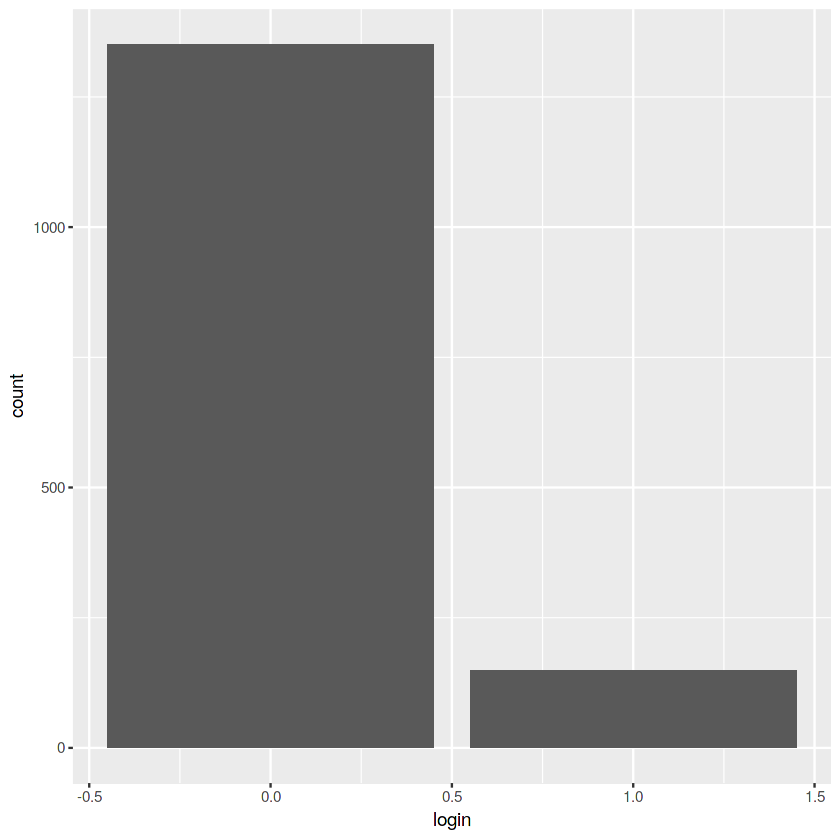

In [5]:
ggplot(train, aes(x = login,fill = login))+ geom_bar()

## Correlation
- 결측값을 제외한 수치형 변수들의 상관관계를 확인해본 결과는 다음과 같다.

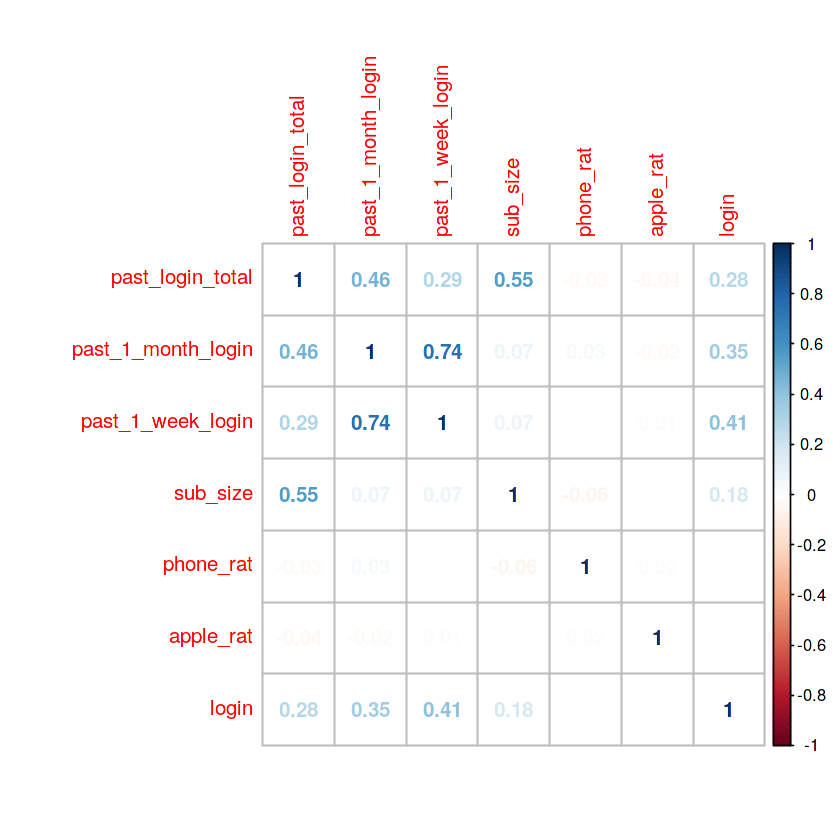

In [6]:
cc <- cor(train[,c('past_login_total','past_1_month_login','past_1_week_login','sub_size','phone_rat','apple_rat','login')],use="complete.obs")
corrplot(cc,method = 'number')

- 과거 1주일간 로그인 횟수와 과거 1달간 로그인 횟수간 관계는 0.74의 높은 양의 상관관계를 보인다.
    - 즉, 1주일간 로그인 횟수가 많다면, 1달간 로그인 횟수도 많다는 의미이다.
- 과거 로그인 총 횟수와 제출 횟수간 관계는 0.55로 양의 상관관계를 보인다. 
    - 제출을 하기위해서는 로그인이 필수이기 때문에, 이런 결과를 보이는 듯 하다.
- Target variable(login)은 과거 1주일간 로그인 횟수, 과거 1달간 로그인 횟수, 과거 로그인 총 횟수, 제출 횟수들과 약한 양의 상관 관계를 보인다.

In [7]:
colSums(is.na(all))

person_id                Sex   past_login_total past_1_month_login 
                 0                  0                227                227 
 past_1_week_login           sub_size         email_type          phone_rat 
               227                  0                  0                  0 
         apple_rat              login      Train_or_Test 
                 0                682                  0

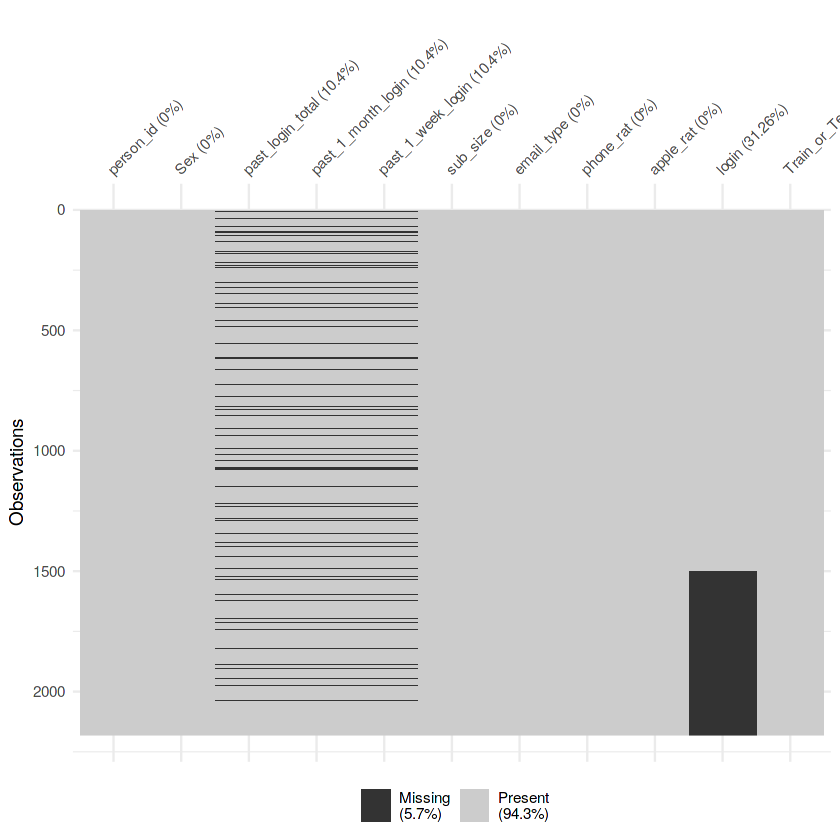

In [8]:
vis_miss(all)

- 전체 데이터의 6.2%가 결측값으로 나타났다. 6.2%의 1/3은 Test data의 label value로 나타났다.
- 나머지 결측값은 past_login_total, past_1_month_login, past_1_week_login에서 동시에 등장했다. 

In [9]:
all$computer_rat <- 1 - all$phone_rat

In [10]:
past_login_loc <- which(is.na(all$past_login_total))

for (i in past_login_loc){
    all[,3][i] <- 0
    all[,4][i] <- 0
    all[,5][i] <- 0
}

multiplot function : http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/

In [11]:
# Multiple plot function
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

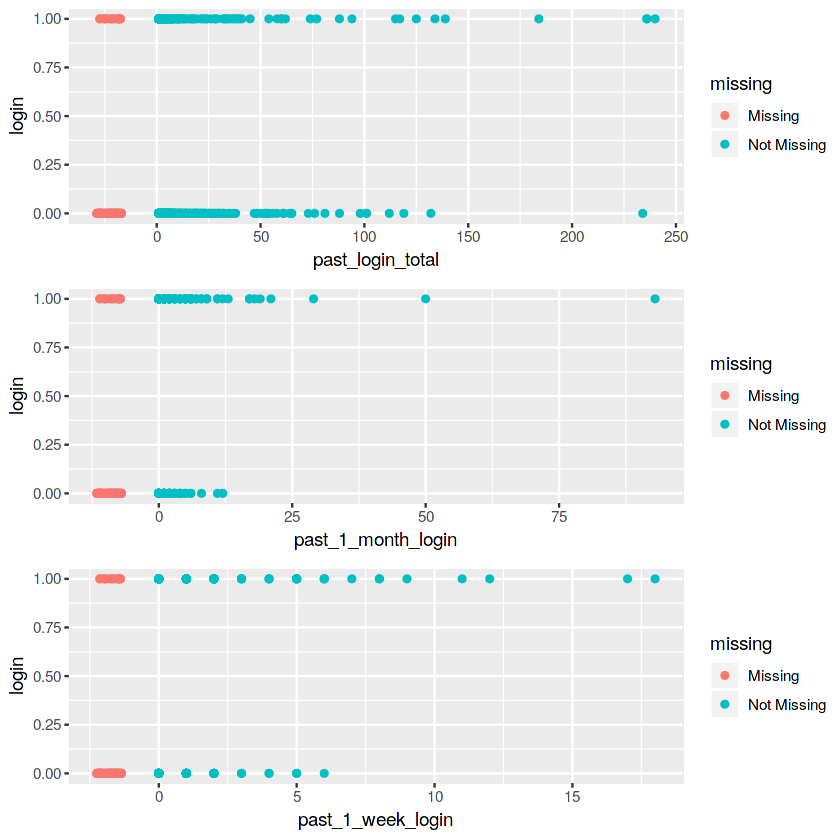

In [12]:
p1 <- ggplot(train,
       aes(x = past_login_total,
           y = login)) +
 geom_miss_point()

p2 <- ggplot(train,
       aes(x = past_1_month_login,
           y = login)) +
 geom_miss_point()

p3 <- ggplot(train,
       aes(x = past_1_week_login,
           y = login)) +
 geom_miss_point()

multiplot(p1,p2,p3,cols=1)

Training Data를 이용하여 과거에 로그인한 총 횟수와 로그인 여부간의 관계를 확인해보았다.
- 과거에 로그인한 총 횟수가 높을수록 로그인 여부도 1인 경향을 보였다. 
- 과거 1달 동안 로그인 총 횟수가 높을수록 로그인 여부도 1인 경향을 보였다.
- 과거 1주일 동안 로그인 총 횟수가 높을수록 로그인 여부도 1인 경향을 보였다. 

In [13]:
all$Sex <- factor(all$Sex)
all$email_type <- factor(all$email_type)

all <-  all %>% select(-person_id)

In [14]:
train <- all %>% filter(Train_or_Test == 'Train') %>% select(-Train_or_Test)
test <- all %>% filter(Train_or_Test == 'Test') %>% select(-Train_or_Test)

## Modeling

In [15]:
train_label <- train$login
test_label <- test$login

In [16]:
x_train <- model.matrix(~.-1,data=train[,-9]) %>% data.frame
x_test <- model.matrix(~.-1,data=test[,-9]) %>% data.frame

dtrain <- xgb.DMatrix(data = as.matrix(x_train), label = train_label)
dtest <- xgb.DMatrix(data = as.matrix(x_test))

In [17]:
set.seed(9302)
xgb_cv <- xgboost::xgb.cv(
  data = dtrain,
  objective = "binary:logistic", verbos = 1,
  nrounds = 1000, subsample = 0.67,
  colsample_bytree = 0.8,
  nfold = 5, eta = 0.01, gamma = 0,
  early_stopping_rounds = 100, max_depth = 4,
  min_child_weight = 5, alpha = 0.5
)
bst <- xgb_cv$best_iteration

[1]	train-error:0.079333+0.002549	test-error:0.084000+0.016786 
Multiple eval metrics are present. Will use test_error for early stopping.
Will train until test_error hasn't improved in 100 rounds.

[2]	train-error:0.080167+0.004813	test-error:0.088000+0.016138 
[3]	train-error:0.079333+0.003993	test-error:0.085333+0.013920 
[4]	train-error:0.078000+0.004904	test-error:0.086667+0.013166 
[5]	train-error:0.077833+0.004103	test-error:0.084667+0.016000 
[6]	train-error:0.077333+0.003391	test-error:0.083333+0.016194 
[7]	train-error:0.077500+0.004116	test-error:0.085333+0.016546 
[8]	train-error:0.077500+0.004082	test-error:0.082000+0.013760 
[9]	train-error:0.077000+0.004365	test-error:0.082667+0.011813 
[10]	train-error:0.076500+0.004696	test-error:0.083333+0.012472 
[11]	train-error:0.077167+0.004552	test-error:0.082667+0.013565 
[12]	train-error:0.077000+0.004702	test-error:0.083333+0.013499 
[13]	train-error:0.077000+0.004702	test-error:0.083333+0.013499 
[14]	train-error:0.076833+0.0

In [18]:
params <- list(
  objective = "reg:logistic",
  eval_metric = "auc",
  eta = 0.01,
  gamma = 0,
  max_depth = 4,
  sub_sample =0.67, 
  colsample_bytree = 0.8,
  nthread = -1,
  min_child_weight = 5,
  alpha = 0.5
)

fitting_xgb <- xgb.train(data = dtrain, params = params,nrounds = bst)
prediction_xgb <- predict(fitting_xgb,dtest)

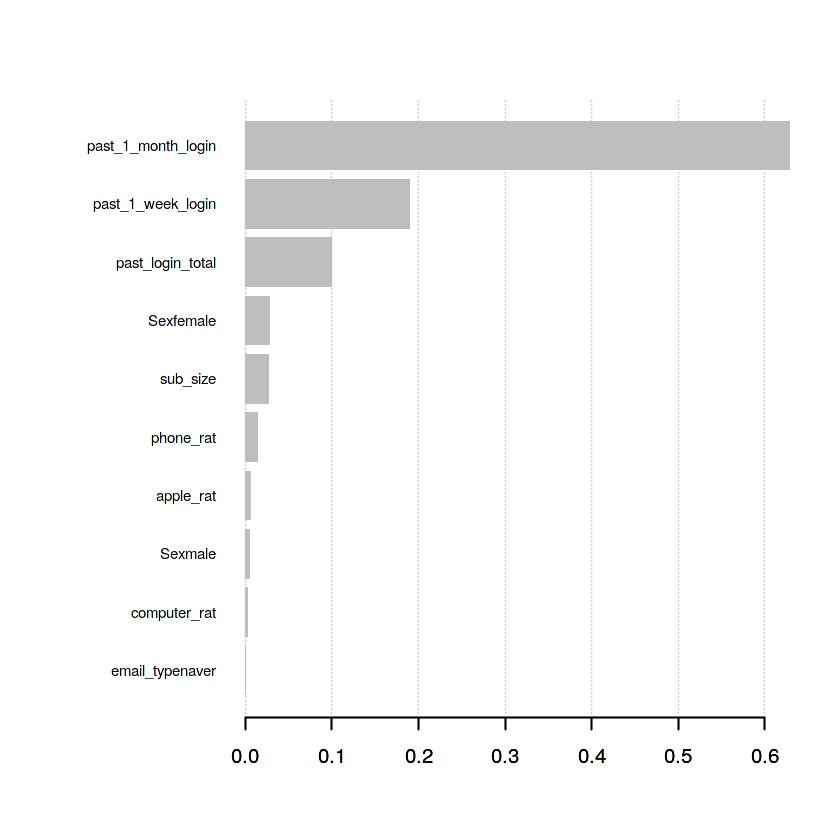

In [19]:
xgb.importance(colnames(dtrain), model = fitting_xgb) %>%
  xgb.plot.importance(top_n = 10)

# LightGBM

In [20]:
x_train <- model.matrix(~.-1,data=train[,-9]) 
x_test <- model.matrix(~.-1,data=test[,-9]) 

In [21]:
train.lgb <- lgb.Dataset(data = x_train, label = train[,9])

In [22]:
lgb.grid <- list(objective = "binary",
                metric = "auc",
                learing_rate = 0.01,
                num_leaves = 15,
                feature_fraction = 0.7,
                bagging_fraction = 0.7,
                bagging_freq = 5
                )

set.seed(0514)
lgb.cv <- lgb.cv(param=lgb.grid, data=train.lgb, learning_rate = 0.01, num_leaves = 15, num_threads = 4, 
                nrounds = 5000, early_stopping_rounds = 50, eval_freq = 20, nfold = 5, stratified = F)               



[1]:	valid's auc:0.549384+0.0177857 
[21]:	valid's auc:0.656669+0.0292829 
[41]:	valid's auc:0.657026+0.0263764 
[61]:	valid's auc:0.657156+0.0302882 


In [23]:
best_iter <- lgb.cv$best_iter

fitting_lgb <- lgb.train(params = lgb.grid,data = train.lgb,learning_rate = 0.01,nrounds = best_iter, eval_freq = 100)
prediction_lgb <- predict(fitting_lgb,x_test)

# Logistic Regression

In [24]:
glm_data <- all
glm_data$login <- as.numeric(glm_data$login)
str(glm_data)

Classes ‘data.table’ and 'data.frame':	2182 obs. of  11 variables:
 $ Sex               : Factor w/ 2 levels "female","male": 2 1 2 2 1 1 2 1 2 1 ...
 $ past_login_total  : num  1 2 1 2 0 4 0 48 2 5 ...
 $ past_1_month_login: num  0 0 0 0 0 0 0 0 0 0 ...
 $ past_1_week_login : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sub_size          : num  0 0 0 0 0 0 0 28 0 0 ...
 $ email_type        : Factor w/ 5 levels "gmail","hanmail",..: 4 5 5 5 4 4 4 1 3 4 ...
 $ phone_rat         : num  0 1 1 0 0 0 0.0625 0 0 0 ...
 $ apple_rat         : num  1 1 0 1 0 ...
 $ login             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ Train_or_Test     : chr  "Train" "Train" "Train" "Train" ...
 $ computer_rat      : num  1 0 0 1 1 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [25]:
tmp_sex <- glm_data$Sex %>%createDummyFeatures(tmp_sex,cols='Sex')

tmp_email <- glm_data$email_type %>%createDummyFeatures(tmp_email,cols='email')

glm_data <- cbind(glm_data,tmp_sex,tmp_email) %>% select(-c(Sex,email_type))

In [26]:
train_set <- glm_data %>% filter(Train_or_Test=="Train") %>% select(-Train_or_Test)
test_set <- glm_data %>% filter(Train_or_Test=="Test") %>% select(-Train_or_Test)

In [27]:
str(train_set)

'data.frame':	1500 obs. of  15 variables:
 $ past_login_total  : num  1 2 1 2 0 4 0 48 2 5 ...
 $ past_1_month_login: num  0 0 0 0 0 0 0 0 0 0 ...
 $ past_1_week_login : num  0 0 0 0 0 0 0 0 0 0 ...
 $ sub_size          : num  0 0 0 0 0 0 0 28 0 0 ...
 $ phone_rat         : num  0 1 1 0 0 0 0.0625 0 0 0 ...
 $ apple_rat         : num  1 1 0 1 0 ...
 $ login             : num  0 0 0 0 0 0 0 0 0 0 ...
 $ computer_rat      : num  1 0 0 1 1 ...
 $ female            : num  0 1 0 0 1 1 0 1 0 1 ...
 $ male              : num  1 0 1 1 0 0 1 0 1 0 ...
 $ gmail             : num  0 0 0 0 0 0 0 1 0 0 ...
 $ hanmail           : num  0 0 0 0 0 0 0 0 0 0 ...
 $ nate              : num  0 0 0 0 0 0 0 0 1 0 ...
 $ naver             : num  1 0 0 0 1 1 1 0 0 1 ...
 $ other             : num  0 1 1 1 0 0 0 0 0 0 ...
 - attr(*, ".internal.selfref")=<externalptr> 


In [28]:
set.seed(930217)
fitting_logistic <- glm(login~scale(past_login_total)+scale(past_1_month_login)+scale(past_1_week_login)+scale(sub_size)
                        +phone_rat+apple_rat+male+female+gmail+hanmail+nate+naver+other,data=train_set, family = binomial)

nothing <- glm(login~1,data = train_set, family = binomial)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [29]:
forwards  <- step(nothing,
                 scope=list(lower=formula(nothing),upper=formula(fitting_logistic)), direction='forward')

Start:  AIC=972.85
login ~ 1



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                            Df Deviance    AIC
+ scale(past_1_month_login)  1   770.95 774.95
+ scale(past_1_week_login)   1   817.39 821.39
+ scale(past_login_total)    1   910.90 914.90
+ scale(sub_size)            1   945.11 949.11
+ male                       1   964.42 968.42
+ female                     1   964.42 968.42
+ nate                       1   968.68 972.68
<none>                           970.85 972.85
+ other                      1   969.38 973.38
+ hanmail                    1   969.82 973.82
+ naver                      1   970.56 974.56
+ gmail                      1   970.59 974.59
+ apple_rat                  1   970.62 974.62
+ phone_rat                  1   970.84 974.84


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=774.95
login ~ scale(past_1_month_login)



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                           Df Deviance    AIC
+ scale(sub_size)           1   754.25 760.25
+ scale(past_login_total)   1   760.92 766.92
+ scale(past_1_week_login)  1   762.46 768.46
+ male                      1   765.20 771.20
+ female                    1   765.20 771.20
<none>                          770.95 774.95
+ nate                      1   770.21 776.21
+ hanmail                   1   770.25 776.25
+ other                     1   770.31 776.31
+ gmail                     1   770.73 776.73
+ phone_rat                 1   770.85 776.85
+ apple_rat                 1   770.95 776.95
+ naver                     1   770.95 776.95


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=760.25
login ~ scale(past_1_month_login) + scale(sub_size)



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                           Df Deviance    AIC
+ scale(past_1_week_login)  1   744.92 752.92
+ male                      1   747.65 755.65
+ female                    1   747.65 755.65
<none>                          754.25 760.25
+ other                     1   752.62 760.62
+ scale(past_login_total)   1   753.26 761.26
+ nate                      1   753.34 761.34
+ hanmail                   1   753.50 761.50
+ gmail                     1   753.76 761.76
+ naver                     1   754.23 762.23
+ phone_rat                 1   754.25 762.25
+ apple_rat                 1   754.25 762.25


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=752.92
login ~ scale(past_1_month_login) + scale(sub_size) + scale(past_1_week_login)



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                          Df Deviance    AIC
+ male                     1   738.36 748.36
+ female                   1   738.36 748.36
<none>                         744.92 752.92
+ scale(past_login_total)  1   743.01 753.01
+ other                    1   743.16 753.16
+ nate                     1   744.12 754.12
+ hanmail                  1   744.37 754.37
+ gmail                    1   744.41 754.41
+ naver                    1   744.87 754.87
+ apple_rat                1   744.92 754.92
+ phone_rat                1   744.92 754.92


Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”


Step:  AIC=748.36
login ~ scale(past_1_month_login) + scale(sub_size) + scale(past_1_week_login) + 
    male



Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

                          Df Deviance    AIC
<none>                         738.36 748.36
+ scale(past_login_total)  1   736.48 748.48
+ other                    1   736.72 748.72
+ hanmail                  1   737.67 749.67
+ nate                     1   737.69 749.69
+ gmail                    1   737.95 749.95
+ naver                    1   738.30 750.30
+ apple_rat                1   738.35 750.35
+ phone_rat                1   738.36 750.36


In [30]:
set.seed(930217)
fitting_logistic <- glm(login~scale(past_1_month_login)+scale(past_1_week_login)+scale(sub_size)
                        +male,data=train_set, family = binomial)

Warning message:
“glm.fit: fitted probabilities numerically 0 or 1 occurred”

In [31]:
prediction_logit <- predict(fitting_logistic,test_set,type='response')
summary(fitting_logistic)


Call:
glm(formula = login ~ scale(past_1_month_login) + scale(past_1_week_login) + 
    scale(sub_size) + male, family = binomial, data = train_set)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.8507  -0.3848  -0.3039  -0.2987   2.5029  

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)               -2.66383    0.15156 -17.577  < 2e-16 ***
scale(past_1_month_login)  1.64920    0.28075   5.874 4.25e-09 ***
scale(past_1_week_login)   0.51444    0.17654   2.914 0.003568 ** 
scale(sub_size)            0.30997    0.07999   3.875 0.000107 ***
male                       0.52197    0.20470   2.550 0.010774 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 970.85  on 1499  degrees of freedom
Residual deviance: 738.36  on 1495  degrees of freedom
AIC: 748.36

Number of Fisher Scoring iterations: 6


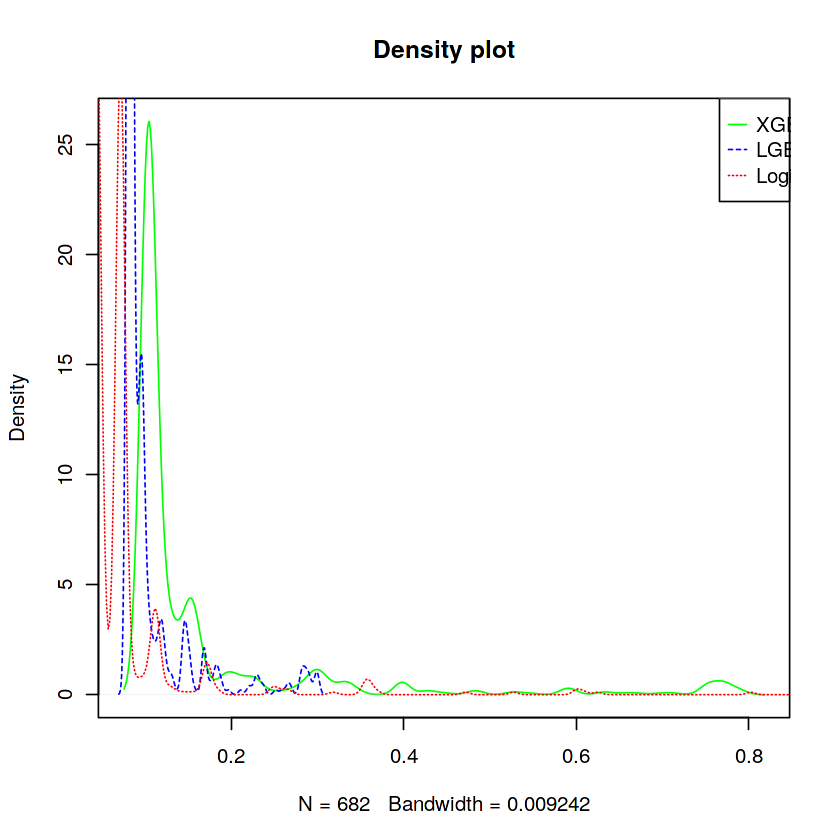

In [32]:
d1 = density(prediction_xgb)
d2 = density(prediction_lgb)
d3 = density(prediction_logit)

plot(d1,col="green",lwd=1,lty=1,main = "Density plot")
lines(d2,col="blue",lwd=1,lty=2)
lines(d3,col="red",lwd=1,lty=3)
legend("topright",legend=c("XGB","LGBM",'Logit'),
       col=c("green","blue","red"),lty=1:3)

# Stacking Model

In [33]:
test_id <- fread('../input/test.csv',stringsAsFactors = F) %>% select(person_id)

prediction <- cbind(prediction_xgb,prediction_lgb,prediction_logit)
prediction <- as.data.frame(prediction)

In [34]:
prediction$sum_prediction <- prediction$prediction_xgb+prediction$prediction_lgb+prediction$prediction_logit
prediction$rank <- rank(prediction$sum_prediction)

In [35]:
# Min max Normalization function 

normalized <- function(x) {
    (x - min(x)) / (max(x) - min(x))
}

In [36]:
prediction$normailzed_rank <- normalized(prediction$rank)
prediction$mean_stacking <- (prediction$prediction_xgb+prediction$prediction_lgb+prediction$prediction_logit)/3

# Output 

In [37]:
df_mean_stacking <- data.frame(test_id,prediction$mean_stacking)
df_normalized_rank <- data.frame(test_id,prediction$normailzed_rank)
df_xgb_pred <- data.frame(test_id,prediction$prediction_xgb)
df_lgb_pred <- data.frame(test_id,prediction$prediction_lgb)
df_logistic_pred <- data.frame(test_id,prediction$prediction_logit)

write.csv(df_mean_stacking,"mean_stacking_submissuon.csv",row.names=F)
write.csv(df_normalized_rank,"rank_submission.csv",row.names=F)
write.csv(df_xgb_pred,"xgb_prediction.csv",row.names = F)
write.csv(df_lgb_pred,"lgb_prediction.csv",row.names =F)
write.csv(df_logistic_pred,"logistic_prediction.csv",row.names = F)